<a href="https://colab.research.google.com/github/MizanMustakim/thesis_work/blob/main/RoadDamageDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Old Work



In [ ]:
from mrcnn import modellib

ModuleNotFoundError: ignored

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib

In [ ]:
print(tf.__version__)

2.9.2


In [ ]:
import os
import zipfile
from bs4 import BeautifulSoup
from xml.etree import ElementTree as ET

import pandas as pd
import numpy as np
import json

import cv2
import matplotlib.pyplot as plt

In [ ]:
! wget https://bigdatacup.s3.ap-northeast-1.amazonaws.com/2022/CRDDC2022/RDD2022/Country_Specific_Data_CRDDC2022/RDD2022_China_Drone.zip 

--2023-01-26 05:18:44--  https://bigdatacup.s3.ap-northeast-1.amazonaws.com/2022/CRDDC2022/RDD2022/Country_Specific_Data_CRDDC2022/RDD2022_China_Drone.zip
Resolving bigdatacup.s3.ap-northeast-1.amazonaws.com (bigdatacup.s3.ap-northeast-1.amazonaws.com)... 52.219.8.234, 52.219.8.174, 52.219.1.23, ...
Connecting to bigdatacup.s3.ap-northeast-1.amazonaws.com (bigdatacup.s3.ap-northeast-1.amazonaws.com)|52.219.8.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160193541 (153M) [application/zip]
Saving to: ‘RDD2022_China_Drone.zip’

RDD2022_China_Drone 100%[===================>] 152.77M  18.3MB/s    in 9.3s    

2023-01-26 05:18:54 (16.3 MB/s) - ‘RDD2022_China_Drone.zip’ saved [160193541/160193541]



In [ ]:
local_zip = "./RDD2022_China_Drone.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall("./RDD")
zip_ref.close()

In [ ]:
dir = "./RDD/China_Drone/train/annotations/xmls"
print("Number of files:", len(os.listdir(dir)))
# os.listdir(dir)[:10]

Number of files: 2401


In [ ]:
img_dir = "./RDD/China_Drone/train/images"
print("Number of files:",len(os.listdir(img_dir)))
# os.listdir(img_dir)[:10]

Number of files: 2401


In [ ]:
path = "./RDD/China_Drone/train/annotations/xmls" 

cls_names = []
for file in os.listdir(path):
    infile_xml = open(path+'/'+file)
    tree = ET.parse(infile_xml)
    root = tree.getroot()
    
    for obj in root.iter('object'):
        cls_nam = obj.find('name').text
        cls_names.append(cls_nam)

print("Number of labels：" + str(len(cls_names)))

Number of labels：3840


In [ ]:
with open(path+'/'+os.listdir(path)[0], 'r') as f:
    data = f.read()
print(data)

<annotation>
	<folder>images</folder>
	<filename>China_Drone_001930.jpg</filename>
	<size>
		<width>512</width>
		<height>512</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>D10</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>1</xmin>
			<ymin>421</ymin>
			<xmax>177</xmax>
			<ymax>452</ymax>
		</bndbox>
	</object>
</annotation>


In [ ]:
def processing(path):
    
    data = {"file_name":{},
            "width": {},
            "height": {},
            "class_name": {},
            "pose": {},
            "truncated": {},
            "difficult": {},
            "xmin": {},
            "ymin": {},
            "xmax": {},
            "ymax": {},
           }

    i = 0
    for file in os.listdir(path):
        infile_xml = open(path + '/' + file)
        tree = ET.parse(infile_xml)
        root = tree.getroot()

        for obj in root.iter('object'):
            cls_name = obj.find('name').text
            pose = obj.find('pose').text
            truncated = obj.find('truncated').text
            difficult = obj.find('difficult').text

            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            data['class_name'][i] = cls_name
            data['pose'][i] = pose
            data['truncated'][i] = truncated
            data['difficult'][i] = difficult
            data['xmin'][i] = xmin
            data['ymin'][i] = ymin
            data['xmax'][i] = xmax
            data['ymax'][i] = ymax

            for f in root.iter('filename'):
                data['file_name'][i] = f.text

            for s in root.iter('size'):
                width = s.find('width').text
                height = s.find('height').text

                data['width'][i] = width
                data['height'][i] = height

            i += 1
            
    return data

In [ ]:
data = processing(path)
jsonf = open("./RDD/data.json", 'w')
json.dump(data, jsonf)
jsonf.close()

with open("./RDD/data.json") as file:
    d = json.load(file)
df = pd.DataFrame(d)
df.head()

,file_name,width,height,class_name,pose,truncated,difficult,xmin,ymin,xmax,ymax
0,China_Drone_001930.jpg,512,512,D10,Unspecified,1,0,1,421,177,452
1,China_Drone_001158.jpg,512,512,D10,Unspecified,1,0,240,320,512,371
2,China_Drone_000384.jpg,512,512,Repair,Unspecified,1,0,1,1,343,275
3,China_Drone_002185.jpg,512,512,Repair,Unspecified,1,0,1,58,72,155
4,China_Drone_000074.jpg,512,512,D00,Unspecified,0,0,321,320,354,496


In [ ]:
df.shape

(3840, 11)

In [ ]:
def draw_img(img_file, df):
    
    img = cv2.imread(img_file)
    img_name = img_file.split('/')[-1]
    
    img_info = df[df['file_name'] == img_name]
    
    for i in range(img_info.shape[0]):
        cls_name = img_info['class_name'][i]
        xmin = img_info['xmin'][i]
        ymin = img_info['ymin'][i]
        xmax = img_info['xmax'][i]
        ymax = img_info['ymax'][i]
        
        font = cv2.FONT_HERSHEY_PLAIN
        
        cv2.putText(img, cls_name, (xmin+20,ymin+30), font, 1, (0,255,125), 1, cv2.LINE_8)
        
        cv2.rectangle(img, (xmin,ymin), (xmax, ymax), (0,255,0), 2)
        
    return img

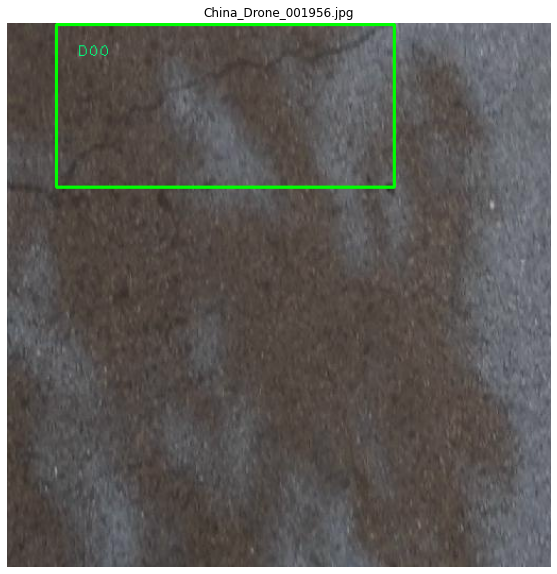

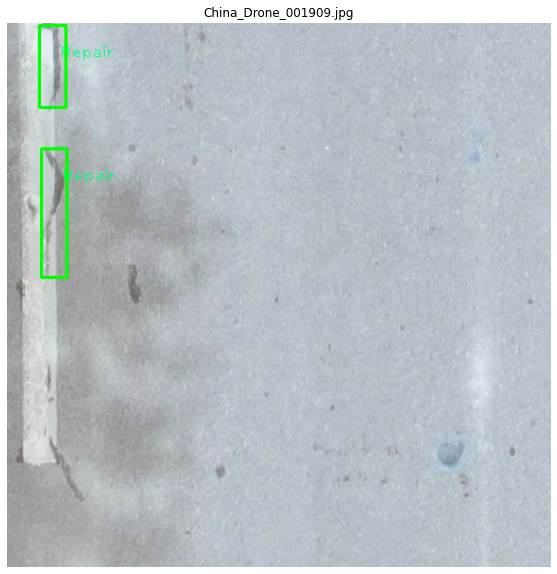

In [ ]:
# x = r"I:\RDD2022\RDD2022_all_countries\China_Drone\China_Drone\train\images\China_Drone_000001.jpg"
# # x.split("\\")[-1]

for file in os.listdir("./RDD/China_Drone/train/images")[:2]:
    plt.figure(figsize=(10,10))
    plt.imshow(draw_img("./RDD/China_Drone/train/images/" + file, df))
    plt.title(f"{file}")
    plt.axis('off')
    plt.show()

### YOLO work

> Dataset Download

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d mustakimmizan/rdd-thesis-dataset

100% 12.4G/12.4G [06:58<00:00, 34.6MB/s]
100% 12.4G/12.4G [06:58<00:00, 31.7MB/s]


In [ ]:
! unzip /content/rdd-thesis-dataset.zip -d /content/drive/MyDrive

In [ ]:
from bs4 import BeautifulSoup
import json
import os
import pandas as pd, numpy as np
from xml.etree import ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import pickle



import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Lambda, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, concatenate
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.layers import Flatten, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop


In [ ]:
def processing(pathfiles):
    
    data = {"file_name":{},
            "width": {},
            "height": {},
            "class_name": {},
            "xmin": {},
            "ymin": {},
            "xmax": {},
            "ymax": {},
           }

    i = 0
    for path in pathfiles:
        for file in os.listdir(path):
            infile_xml = open(path + '/' + file)
            tree = ET.parse(infile_xml)
            root = tree.getroot()

            for obj in root.iter('object'):
                cls_name = obj.find('name').text

                bndbox = obj.find('bndbox')
                xmin = eval(bndbox.find('xmin').text)
                ymin = eval(bndbox.find('ymin').text)
                xmax = eval(bndbox.find('xmax').text)
                ymax = eval(bndbox.find('ymax').text)

                
                data['class_name'][i] = cls_name


                data['xmin'][i] = xmin
                data['ymin'][i] = ymin
                data['xmax'][i] = xmax
                data['ymax'][i] = ymax
                

                for f in root.iter('filename'):
                    data['file_name'][i] = f.text

                for s in root.iter('size'):
                    width = s.find('width').text
                    height = s.find('height').text

                    data['width'][i] = width
                    data['height'][i] = height

                i += 1
            
    return data

In [ ]:
def annotation_processing(path):
    data = processing(path)

    jsonf = open("/content/drive/MyDrive/data.json", 'w')
    json.dump(data, jsonf)
    jsonf.close()

    with open("/content/drive/MyDrive/data.json") as file:
        d = json.load(file)
    df = pd.DataFrame(d)
    return df

In [ ]:
CN_dron_xml_path = "/content/drive/MyDrive/China_Drone/China_Drone/train/annotations/xmls"
CN_bike_xml_path = "/content/drive/MyDrive/China_MotorBike/China_MotorBike/train/annotations/xmls"
czech_xml_path = "/content/drive/MyDrive/Czech/Czech/train/annotations/xmls"
india_xml_path = "/content/drive/MyDrive/India/India/train/annotations/xmls"
japan_xml_path = "/content/drive/MyDrive/Japan/Japan/train/annotations/xmls"
norway_xml_path = "/content/drive/MyDrive/Norway/Norway/train/annotations/xmls"
usa_xml_path = "/content/drive/MyDrive/United_States/United_States/train/annotations/xmls"

file_path = [CN_dron_xml_path, CN_bike_xml_path, czech_xml_path, india_xml_path, japan_xml_path, norway_xml_path, usa_xml_path]
# CN_dron_df = annotation_processing(CN_dron_xml_path)
# CN_bike_df = annotation_processing(CN_bike_xml_path)
# czech_df = annotation_processing(czech_xml_path)
# india_df = annotation_processing(india_xml_path)
# japan_df = annotation_processing(japan_xml_path)
# norway_df = annotation_processing(norway_xml_path)
# usa_df = annotation_processing(usa_xml_path)
main_df = annotation_processing(file_path)

In [ ]:
# main_df = pd.concat([CN_dron_df, CN_bike_df, czech_df, india_df, japan_df, norway_df, usa_df])
with open("/content/drive/MyDrive/data.json") as file:
    d = json.load(file)
main_df = pd.DataFrame(d)
main_df.drop(
            main_df.index[(
            main_df["class_name"].isin(["D44", "D50", "Repair", "D43", "D01", "D11", "Block crack", "D0w0"])
            )], 
            axis=0,
            inplace=True)

main_df

,file_name,width,height,class_name,xmin,ymin,xmax,ymax
0,China_Drone_001400.jpg,512,512,D00,169.0,70.0,340.0,394.0
3,China_Drone_001404.jpg,512,512,D10,1.0,200.0,72.0,222.0
4,China_Drone_001405.jpg,512,512,D10,108.0,140.0,235.0,173.0
5,China_Drone_001406.jpg,512,512,D10,1.0,49.0,292.0,99.0
6,China_Drone_001407.jpg,512,512,D10,1.0,109.0,370.0,156.0
...,...,...,...,...,...,...,...,...
70239,United_States_001271.jpg,640,640,D00,331.0,388.0,480.0,639.0
70240,United_States_001231.jpg,640,640,D00,74.0,418.0,170.0,640.0
70241,United_States_001482.jpg,640,640,D20,110.0,470.0,252.0,640.0
70242,United_States_001299.jpg,640,640,D00,194.0,409.0,259.0,621.0


In [ ]:
main_df["class_name"].unique()

array(['D00', 'D10', 'D20', 'D40'], dtype=object)

In [ ]:
main_df["class_name"].value_counts()

D00    26857
D10    11869
D20    11754
D40     8256
Name: class_name, dtype: int64

> Processing the Image

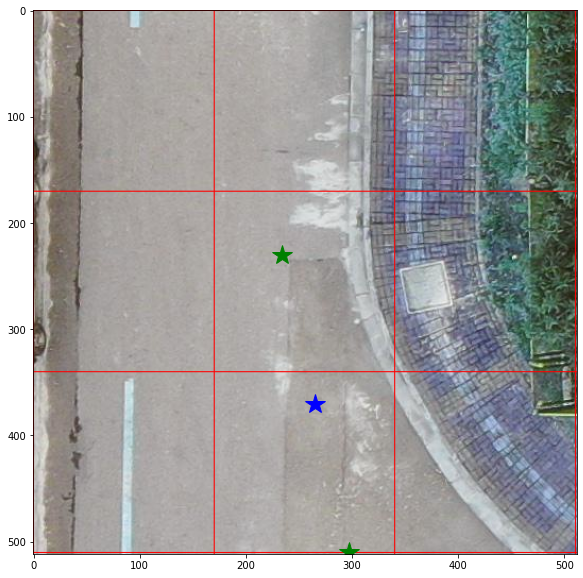

In [ ]:
p = "/content/drive/MyDrive/RDD/China_Drone/train/images/China_Drone_001402.jpg"
img = cv2.imread(p)
# img = img / 255
plt.figure(figsize=(10,10))

dx = img.shape[0] // 3
dy = img.shape[1] // 3
color = [255,0,0]
img[:, ::dy] = color
img[::dx, :] = color
plt.imshow(img)
plt.plot(234,230, "g*", markersize=20)
plt.plot(297,510, "g*", markersize=20)
plt.plot(265.5,370, "b*", markersize=20)
plt.show()

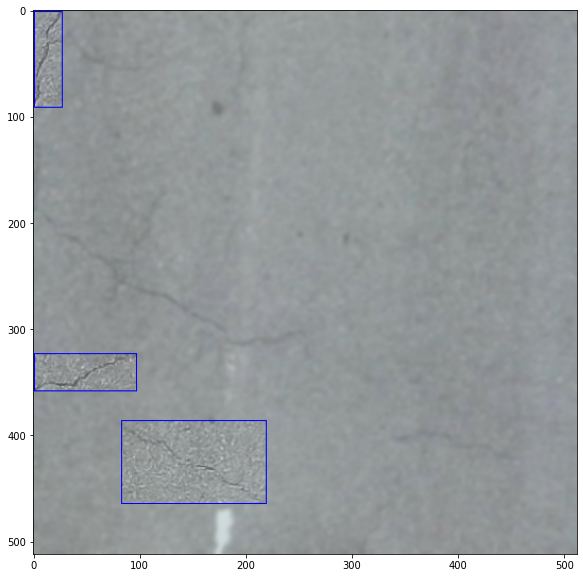

In [ ]:
# def gaussian_blur_augmentation(image_path, bbox, sigma=51):
#     image = cv2.imread(image_path)
#     height, width, _ = image.shape
#     # black = np.zeros((height, width,3), dtype=np.uint8)
#     blurred = cv2.GaussianBlur(image, (5,5), sigma)
#     xmin, ymin, xmax, ymax = bbox
#     blurred[ymin:ymax, xmin:xmax, :] = image[ymin:ymax, xmin:xmax, :]
#     return blurred


'''For single bounding box'''
# def gaussian_blur_augmentation(image_path, bbox, sigma=3):
#     image = cv2.imread(image_path)
#     height, width, _ = image.shape
#     xmin, ymin, xmax, ymax = bbox
#     mask = np.zeros((height, width, 3), dtype=np.uint8)
#     mask[ymin:ymax, xmin:xmax, :] = 1
#     inverted_mask = 1 - mask
#     blurred_image = cv2.GaussianBlur(image, (0,0), sigma)
#     blended_image = blurred_image * inverted_mask + image * mask
#     return blended_image


'''For multiple bounding boxes'''
def gaussian_blur_augmentation(image_path, bboxes, sigma=2):
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    
    # blended_image = np.zeros((height, width, 3), dtype=np.uint8)
    mask = np.zeros((height, width, 3), dtype=np.uint8)
    
    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        mask[ymin:ymax, xmin:xmax, :] = 1
    inverted_mask = 1 - mask
    # image = image / 255.0
    blurred_image = cv2.GaussianBlur(image, (0,0), sigma)
    blended_image = (blurred_image * inverted_mask + image * mask)
    
    return blended_image


p = "/content/drive/MyDrive/RDD/China_Drone/train/images/China_Drone_002070.jpg"
bbox = [[1, 323, 97, 358], [83, 386, 219, 464], [1, 1, 27, 91]]
img = gaussian_blur_augmentation(p, bbox)

plt.figure(figsize=(10,10))
for box in bbox:
    xmin, ymin, xmax, ymax = box
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,0,255), 1)
plt.imshow(img)
plt.show()
# img

> The kernel size that OpenCV uses when you pass (0, 0) as the kernel size and a sigma value of 5 is automatically calculated based on the sigma value. The calculation for the kernel size is not a straightforward equation, but OpenCV uses a heuristic method to determine the kernel size. In this case, the calculated kernel size would be approximately (31, 31).

In [ ]:
int(2 * np.ceil(3 * 5) + 1)

31

In [ ]:
img

In [ ]:
# plt.figure(figsize=(10,10))
# plt.imshow(cv2.imread(p))
# plt.show()
# print(img- cv2.imread(p))
# plt.imshow(cv2.GaussianBlur(cv2.imread(p), (5,5), 5))
# print(img - cv2.GaussianBlur(cv2.imread(p), (5,5), 5))
a = np.array([], dtype= "uint8")
b = np.append(a, img)
b.shape

(786432,)

> **Done!**

In [ ]:
def read(img_path, dataframe):
    
    cls_size = dataframe["class_category"].unique().shape[0]
    # num_anchors = 3
    grid_size = 7
    label_list = [] 
    img_list = []
    for i in range(dataframe.shape[0]):
        image = cv2.imread(img_path+"/"+dataframe["file_name"][i])      #******BUG
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_h, image_w = eval(dataframe["height"][i]), eval(dataframe["width"][i])
        
        image = cv2.resize(image, dsize=(448,448))
        # image = image / 255.0
        
        img_list.append(image)
        
        xmin = dataframe["xmin"][i]
        ymin = dataframe["ymin"][i]
        xmax = dataframe["xmax"][i]
        ymax = dataframe["ymax"][i]
        
        cls = int(dataframe["class_category"][i])
        
        x = (xmin + xmax) / 2 / image_w
        y = (ymin + ymax) / 2 / image_h
        w = (xmax - xmin) / image_w
        h = (ymax - ymin) / image_h

        loc = [grid_size * x, grid_size * y]
        loc_i = int(loc[1])
        loc_j = int(loc[0])

        y = loc[1] - loc_i
        x = loc[0] - loc_j

        label_matrix = np.zeros([grid_size,grid_size,(5 + cls_size)])
        if label_matrix[loc_i, loc_j, ((5 + cls_size) - 1)] == 0:
            label_matrix[loc_i, loc_j, cls] = 1
            label_matrix[loc_i, loc_j, cls_size:((5 + cls_size) - 1)] = [x, y, w, h]
            label_matrix[loc_i, loc_j, ((5 + cls_size) - 1)] = 1

        
        # x_center = xmin * grid_size / image_w
        # y_center = ymin * grid_size / image_h
        # w = xmax * grid_size / image_w
        # h = ymax * grid_size / image_h
        
        # x_cell = int(x_center)
        # y_cell = int(y_center)
        
        # label_matrix = np.zeros([grid_size,grid_size,(5 + cls_size)])
        # label_matrix[y_cell, x_cell, 0:4] = x_center, y_center, w, h
        # label_matrix[y_cell, x_cell, 4] = 1.0
        # label_matrix[y_cell, x_cell, 5 + cls] = 1.0

        label_list.append(label_matrix)

    img_array = np.array(img_list)
    label_array = np.array(label_list)
         
    return img_array, label_array

In [ ]:
p = "/content/drive/MyDrive/RDD/China_Drone/train/images/China_Drone_001407.jpg"

d = annotation_df[annotation_df["file_name"] == p.split("/")[-1]]

# boxes = list()
# for i in range(d.shape[0]):
#     xmin = d["xmin"][i]
#     ymin = d["ymin"][i]
#     xmax = d["xmax"][i]
#     ymax = d["ymax"][i]

#     boxes.append([xmin, ymin, xmax, ymax])

# boxes
d

,file_name,width,height,class_name,class_category,xmin,ymin,xmax,ymax
5,China_Drone_001407.jpg,512,512,D10,2,1,109,370,156
6,China_Drone_001407.jpg,512,512,D00,1,39,1,83,96
7,China_Drone_001407.jpg,512,512,D10,2,365,165,512,196
8,China_Drone_001407.jpg,512,512,D00,1,2,272,111,333


In [ ]:
def read(img_path, dataframe):
    
    cls_size = dataframe["class_category"].unique().shape[0]
    
    # num_anchors = 3
    grid_size = 7
    label_list = [] 
    img_list = []

    tf.random.set_seed(42)
    for path in img_path:
        for files in os.listdir(path):

            new_df = dataframe[dataframe["file_name"] == files]

            image = cv2.imread(path+"/"+files)
            image_h, image_w = image.shape[0], image.shape[1]
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, dsize=(112,112))
            image = image / 255.0
            
            img_list.append(image)

            label_matrix = np.zeros([grid_size,grid_size,(5 + cls_size)])

            for i in range(new_df.shape[0]):
                # image_h, image_w = eval(new_df["height"][i]), eval(new_df["width"][i])
                xmin = new_df["xmin"][i]
                ymin = new_df["ymin"][i]
                xmax = new_df["xmax"][i]
                ymax = new_df["ymax"][i]
            
                cls_idx = int(new_df["class_category"][i])
            
                x = (xmin + xmax) / 2 / image_w
                y = (ymin + ymax) / 2 / image_h
                w = (xmax - xmin) / image_w
                h = (ymax - ymin) / image_h

                loc = [grid_size * x, grid_size * y]
                
                loc_i = int(loc[0]) + 1 if type(loc[0]) == "float" else int(loc[0])
                loc_j = int(loc[1]) + 1 if type(loc[1]) == "float" else int(loc[1])

                # y = loc[1] - loc_i
                # x = loc[0] - loc_j

                if label_matrix[loc_i, loc_j, ((5 + cls_size) - 1)] == 0:
                    label_matrix[loc_i, loc_j, cls] = 1
                    label_matrix[loc_i, loc_j, cls_size:((5 + cls_size) - 1)] = [x, y, w, h]
                    label_matrix[loc_i, loc_j, ((5 + cls_size) - 1)] = 1


            label_list.append(label_matrix)
        print("INFO::: \t{} processing done!".format(path.split("/")[-3]))

    # img_array = np.array(img_list)
    # label_array = np.array(label_list)
    # img_array = tf.convert_to_tensor(img_list)
    # label_array = tf.convert_to_tensor(label_list)
         
    return img_list, label_list

In [ ]:
CH_drone_img_path = "/content/drive/MyDrive/RDD/China_Drone/train/images"
CH_bike_img_path = "/content/drive/MyDrive/China_MotorBike/China_MotorBike/train/images"
czech_img_path = "/content/drive/MyDrive/Czech/Czech/train/images"
india_img_path = "/content/drive/MyDrive/India/India/train/images"
japan_img_path = "/content/drive/MyDrive/Japan/Japan/train/images"
norway_img_path = "/content/drive/MyDrive/Norway/Norway/train/images"
usa_img_path = "/content/drive/MyDrive/United_States/United_States/train/images"

img_path = [CH_drone_img_path, CH_bike_img_path, czech_img_path, india_img_path, japan_img_path, norway_img_path, usa_img_path]
img, label = read(img_path, main_df)

INFO::: 	China_Drone processing done!
INFO::: 	China_MotorBike processing done!
INFO::: 	Czech processing done!
INFO::: 	India processing done!
INFO::: 	Japan processing done!
INFO::: 	Norway processing done!
INFO::: 	United_States processing done!


In [ ]:
def read(img_path, dataframe):
    
    cls_size = dataframe["class_name"].unique().shape[0]
    cls = dataframe["class_name"].unique()
    grid_size = 4
    label_list = [] 
    img_list = []
    sigma = 2

    # tf.random.set_seed(42)
    for path in img_path:
        for files in os.listdir(path):

            new_df = dataframe[dataframe["file_name"] == files]

            image = cv2.imread(path+"/"+files)
            image_h, image_w = image.shape[0], image.shape[1]
            # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # image = cv2.resize(image, dsize=(448,448))

            mask = np.zeros((image_h, image_w, 3), dtype=np.uint8)                

            label_matrix = np.zeros([grid_size,grid_size,(5 + cls_size)])

            for i in range(new_df.shape[0]):
                xmin = new_df["xmin"][i]
                ymin = new_df["ymin"][i]
                xmax = new_df["xmax"][i]
                ymax = new_df["ymax"][i]
            
                mask[int(ymin) : int(ymax), int(xmin) : int(xmax), :] = 1

                cls_idx = np.where(cls == new_df["class_name"][i])[0][0]
            
                x = (xmin + xmax) / 2 / image_w
                y = (ymin + ymax) / 2 / image_h
                w = (xmax - xmin) / image_w
                h = (ymax - ymin) / image_h

                loc = [grid_size * x, grid_size * y]
                
                loc_i = int(loc[0]) + 1 if type(loc[0]) == "float" else int(loc[0])
                loc_j = int(loc[1]) + 1 if type(loc[1]) == "float" else int(loc[1])

                if label_matrix[loc_i, loc_j, ((5 + cls_size) - 1)] == 0:
                    label_matrix[loc_i, loc_j, cls_idx] = 1
                    label_matrix[loc_i, loc_j, cls_size:((5 + cls_size) - 1)] = [x, y, w, h]
                    label_matrix[loc_i, loc_j, ((5 + cls_size) - 1)] = 1

            inverted_mask = 1 - mask
            blurred_image = cv2.GaussianBlur(image, (0,0), sigma)
            blended_image = (blurred_image * inverted_mask + image * mask)
            blended_image = cv2.resize(blended_image, dsize=(224,224))
            img_list.append(blended_image)


            label_list.append(label_matrix)
        print("INFO::: \t{} processing done!".format(path.split("/")[-3]))
         
    return img_list, label_list

In [ ]:
CH_drone_img_path = "/content/drive/MyDrive/RDD/China_Drone/train/images"
CH_bike_img_path = "/content/drive/MyDrive/China_MotorBike/China_MotorBike/train/images"
# czech_img_path = "/content/drive/MyDrive/Czech/Czech/train/images"
# india_img_path = "/content/drive/MyDrive/India/India/train/images"
# japan_img_path = "/content/drive/MyDrive/Japan/Japan/train/images"
# norway_img_path = "/content/drive/MyDrive/Norway/Norway/train/images"
# usa_img_path = "/content/drive/MyDrive/United_States/United_States/train/images"

# img_path = [CH_drone_img_path, CH_bike_img_path, czech_img_path, india_img_path, japan_img_path, norway_img_path, usa_img_path]
img_path = [CH_drone_img_path, CH_bike_img_path]
img, label = read(img_path, main_df)

INFO::: 	China_Drone processing done!
INFO::: 	China_MotorBike processing done!


In [ ]:
img = np.array(img)
label = np.array(label)

In [ ]:
img.shape, label.shape

((4378, 224, 224, 3), (4378, 4, 4, 9))

> **Output Size** = *grid height* * *grid width* * *Anchor Box* * (5 + *number of classes*)

Here, I used anchor size is 1

In [ ]:
tf.keras.backend.clear_session()

class CustomReshape(tf.keras.layers.Layer):
    def __init__(self, target_shape):
        super(CustomReshape, self).__init__()
        self.target_shape = target_shape

    def call(self, inputs):

        grid1 = self.target_shape[0]
        grid2 = self.target_shape[1]

        class_num = 4
        box = 4
        conf = 1

        class_prob = tf.reshape(inputs[:, :(grid1*grid2*class_num)], (-1,) + tuple([grid1, grid2, class_num]))
        class_prob = tf.keras.activations.softmax(class_prob)

        bbox_prob = tf.reshape(inputs[:, (grid1*grid2*class_num) : (grid1*grid2)*(class_num+box)], (-1,) + tuple([grid1, grid2, box]))
        bbox_prob = tf.keras.activations.relu(bbox_prob)

        conf_prob = tf.reshape(inputs[:, (grid1*grid2) * (class_num+box):], (-1,) + tuple([grid1, grid2, conf]))
        conf_prob = tf.keras.activations.sigmoid(conf_prob)

        output = keras.layers.concatenate([class_prob, bbox_prob, conf_prob])

        return output


        # print("Input shape: {}".format(inputs))
        # return tf.reshape(inputs, (-1,) + self.target_shape)

tf.random.set_seed(42)
model = keras.applications.ResNetRS420(weights="imagenet", include_top=False, input_tensor=Input(shape=img[0].shape))

for layer in model.layers:
    layer.trainable = False

x = model.output
x = Flatten()(x)
# x = Dense(32768, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(8192, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(144, activation="relu")(x)          # 5 * 5 * 9
x = CustomReshape(target_shape = label[0].shape)(x)

model = Model(inputs=model.input, outputs=x)

model.summary()

Streaming output truncated to the last 5000 lines.
 BlockGroup3__block_41__act_1 (  (None, 28, 28, 128)  0          ['BlockGroup3__block_41_batch_nor
 Activation)                                                     m_1[0][0]']                      
                                                                                                  
 BlockGroup3__block_41__conv_2   (None, 28, 28, 128)  147456     ['BlockGroup3__block_41__act_1[0]
 (Conv2D)                                                        [0]']                            
                                                                                                  
 BlockGroup3__block_41__batch_n  (None, 28, 28, 128)  512        ['BlockGroup3__block_41__conv_2[0
 orm_2 (BatchNormalization)                                      ][0]']                           
                                                                                                  
 BlockGroup3__block_41__act_2 (  (None, 28, 28, 128)  0   

In [ ]:
train_x, train_y = img[:1700], label[:1700]
test_x, test_y = img[1700:], label[1700:]

tf.random.set_seed(42)
# opt = Adam(learning_rate=0.099)
opt = RMSprop(learning_rate=0.01)
model.compile(optimizer=opt, metrics=["accuracy"], loss="mse")


# checkpoint_filepath = "logs/"
# checkpoint_callback = keras.callbacks.ModelCheckpoint(
#         checkpoint_filepath,
#         monitor="val_loss",
#         save_best_only=True,
#         save_weights_only=True,
# )


h = model.fit(train_x, train_y, 
              validation_data=(test_x, test_y), 
              epochs= 50, 
              batch_size=16, 
              verbose=1,)
        #       callbacks=[
        #         checkpoint_callback,
        #         keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        # ],)

Epoch 1/50
107/107 [==============================] - 116s 613ms/step - loss: 80.5954 - accuracy: 0.3025 - val_loss: 0.1396 - val_accuracy: 0.3120
Epoch 2/50
107/107 [==============================] - 53s 494ms/step - loss: 0.1397 - accuracy: 0.3079 - val_loss: 0.1396 - val_accuracy: 0.3120
Epoch 3/50
107/107 [==============================] - 52s 489ms/step - loss: 0.1397 - accuracy: 0.3079 - val_loss: 0.1396 - val_accuracy: 0.3120
Epoch 4/50
107/107 [==============================] - 52s 490ms/step - loss: 0.1397 - accuracy: 0.3079 - val_loss: 0.1396 - val_accuracy: 0.3120
Epoch 5/50
107/107 [==============================] - 52s 489ms/step - loss: 0.1368 - accuracy: 0.3079 - val_loss: 0.1341 - val_accuracy: 0.3120
Epoch 6/50
107/107 [==============================] - 52s 491ms/step - loss: 0.1343 - accuracy: 0.3079 - val_loss: 0.1341 - val_accuracy: 0.3120
Epoch 7/50
107/107 [==============================] - 52s 489ms/step - loss: 0.1343 - accuracy: 0.3079 - val_loss: 0.1341 - val_

In [ ]:
label[:2000].shape

(2000, 7, 7, 11)

In [ ]:
# inputs = list(range(539))
# tf.reshape(inputs, (-1,)+(7,7,11))
a = np.zeros((3,3,5))
a

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]])

In [ ]:
a[:, :, :2] = [1,2]
a[:, :, 3:] = [4,5]
b = a[:, :, :2]
c = a[:, :, 3:]

In [ ]:
d = keras.layers.concatenate([b,c])

d[:,:,:]

<tf.Tensor: shape=(3, 3, 4), dtype=float32, numpy=
array([[[1., 2., 4., 5.],
        [1., 2., 4., 5.],
        [1., 2., 4., 5.]],

       [[1., 2., 4., 5.],
        [1., 2., 4., 5.],
        [1., 2., 4., 5.]],

       [[1., 2., 4., 5.],
        [1., 2., 4., 5.],
        [1., 2., 4., 5.]]], dtype=float32)>